# Wiki scraper report

### Author:
Łukasz Andryszewski 151930

## Outline

The project consited of:
- Creating a database of 1000 wikipedia articles
- Scraping/Lemmatizing them
- Creating a recommender system

## Creating the database

The database should consist of a wide variety of topics, so the articles should be randomized. This could be achieved by generating 1000 random words and then searching using: 
- https://en.wikipedia.org/w/index.php?search=INPUT_TEXT

Thankfully wikipedia and fandom offer special pages among which, a random article can be entered:
- https://en.wikipedia.org/wiki/Special:Random

To retrieve the data the following parser was created:

In [1]:
import requests
import bs4

def get_title_and_text(url='https://en.wikipedia.org/wiki/Special:Random'):
    response = requests.get(url)
    parsed = bs4.BeautifulSoup(response.text,features="lxml")
    output = ""
    for p in parsed.select('p'):
        output += p.getText()
    return parsed.title.string,response.url,output

Using GET, it loads the html site and joins all paragraphs into one long string. However to ensure the data is interesting if an article containted less than 2000 characters it was exchanged for another article. This is done to exclude bland articles like:
- https://en.wikipedia.org/wiki/1296_in_poetry

The created database is stored as a simple csv file.

## Lemmatizng

To reduce the size of the data and get rid of useless words a word lemmatizer is applied and stopwords are filtered out:

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def word_lemmatizer(string,method):
    stops = stopwords.words('english')
    return list(filter(lambda s: not s in stops,map(WordNetLemmatizer().lemmatize,word_tokenize(string))))

A Lemmatizer is used instead of a Stemmer because of issues in articles interpretability.

Using this methods 1000 articles were downloaded and put into a csv files along with their urls

## Recommender System

To recommend articles a similarity measure must be established between them. The articles are first scored using TF-IDF. The score is calculated the following way:

$$ tfidf(t,d,D) = tf(t,d) \cdot idf(t,D) $$

$ tf(t,d) $ - term frequency in a given document

$ idf(t,D) $ - information the term provides in a domain of documents

$t$ - term, $d$ - document, $D$ - domain of documents

The used vectorizer comes from sklearn library:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False)

The similarity between documents is calculated using the cosine distance measure on the normalized tfidf values. The distance measured is then substracted from 1 transforming it into a similarity measure.

The recommender:
1. downloads the text from the article
2. lemmatizes the article
2. transform the query articles using tfidf 
3. measures similarity to each article in the database
3. returns n most similar articles from the database, along with their similarity scores

In [4]:
def recommend_articles(df,tfidf,queries,n=3):
    recommended = {}
    q_arrays = []

    for query in queries:
        _,url,text = get_title_and_text(query)
        q_stem = " ".join(word_lemmatizer(text))
        q_array = tfidf.transform([q_stem]).toarray()[0]
        q_arrays.append(q_array)
        values = (1-df.apply(lambda x: cosine(x, q_array), axis=1).sort_values())
        recommended[query] = (values[:n])

    return recommended

In [5]:
from src.wiki_scraper.functions.utils import *
from src.wiki_scraper.functions.recommender import *

articles = read_csv(".\\data\\articles.csv")
df,tfidf = fit_articles(articles)

In [6]:
recommend_articles(df,tfidf,[
    "https://en.wikipedia.org/wiki/Communism",
    "https://en.wikipedia.org/wiki/Nirvana_(band)",
    "https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology",
    "https://en.wikipedia.org/wiki/Jesus",
    "https://en.wikipedia.org/wiki/Mars",
    "https://en.wikipedia.org/wiki/FIFA_World_Cup"
])

{'https://en.wikipedia.org/wiki/Communism': https://en.wikipedia.org/wiki/Communist_Party_of_the_Peoples_of_Spain    0.218201
 https://en.wikipedia.org/wiki/Propaganda_in_East_Germany                 0.208621
 https://en.wikipedia.org/wiki/Qiu_He                                     0.184950
 dtype: float64,
 'https://en.wikipedia.org/wiki/Nirvana_(band)': https://en.wikipedia.org/wiki/Taking_Back_Sunday         0.269535
 https://en.wikipedia.org/wiki/Washing_Machine_(album)    0.266175
 https://en.wikipedia.org/wiki/Fighting_Fiction           0.208125
 dtype: float64,
 'https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology': https://en.wikipedia.org/wiki/Keith_Bowman          0.261066
 https://en.wikipedia.org/wiki/Lucija_%C4%8Cok       0.207344
 https://en.wikipedia.org/wiki/Education_in_Delhi    0.196758
 dtype: float64,
 'https://en.wikipedia.org/wiki/Jesus': https://en.wikipedia.org/wiki/Jesus_schl%C3%A4ft,_was_soll_ich_hoffen%3F_BWV_81    0.225867
 https://en.wikipedi

The output of the recommender are the articles with their similarity score.

## Data base analysis



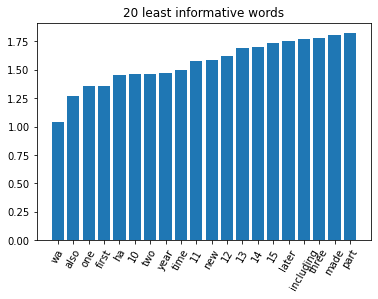

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

values = pd.Series(tfidf.idf_, index=tfidf.get_feature_names_out()).sort_values()[:20]
x,y = values.index,values

plt.bar(x,y)
plt.xticks(rotation = 60)
plt.title("20 least informative words")
plt.show()

This graph shows the least informative words in the entire database according do idf measure. These words appear in most of the articles and do not reveal much about the topic of the article.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

urls = [row[0] for row in articles]
text = [" ".join(row[1:]) for row in articles]
tfidf_matrix = tfidf.transform(text)
similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)

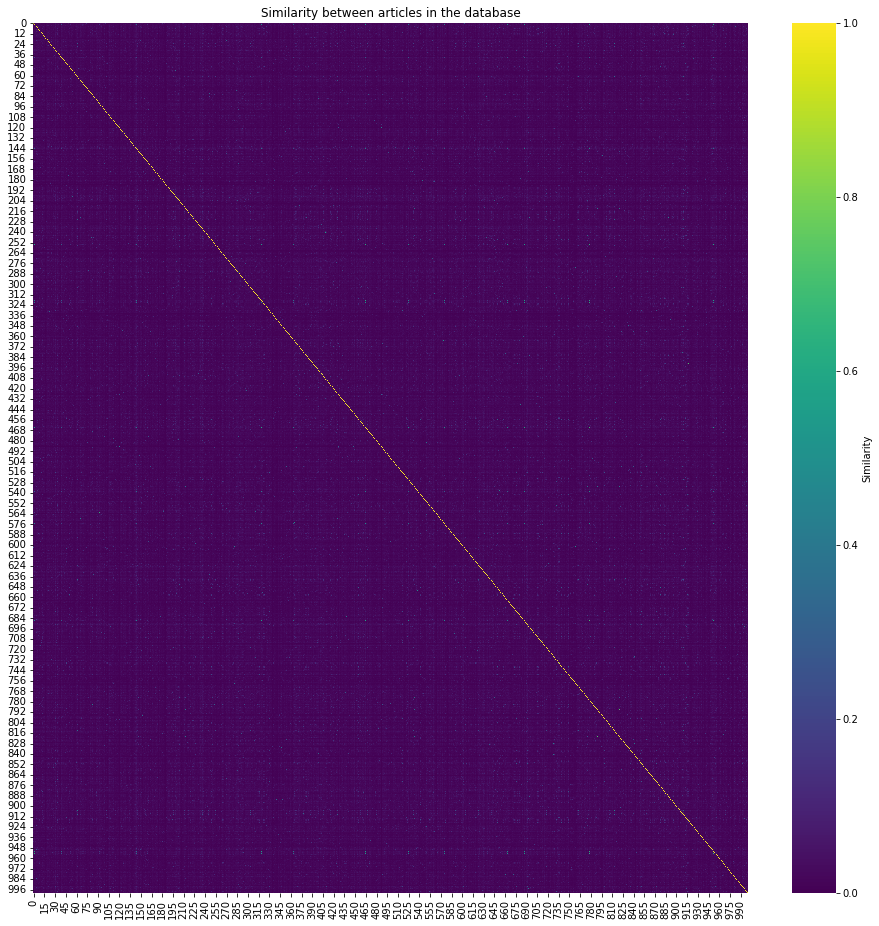

In [9]:
import seaborn as sns

plt.figure(figsize=(16, 16)) 
sns.heatmap(similarities, cmap='viridis', cbar_kws={'label': 'Similarity'})
plt.title('Similarity between articles in the database')
plt.show()

Because the articles were completely randomly selected their similarities are very low as expected.

## Recommendation explanation

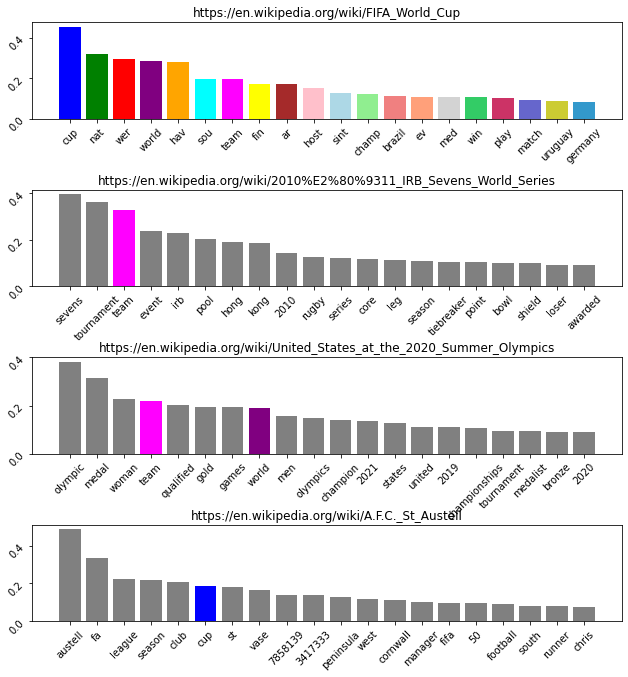

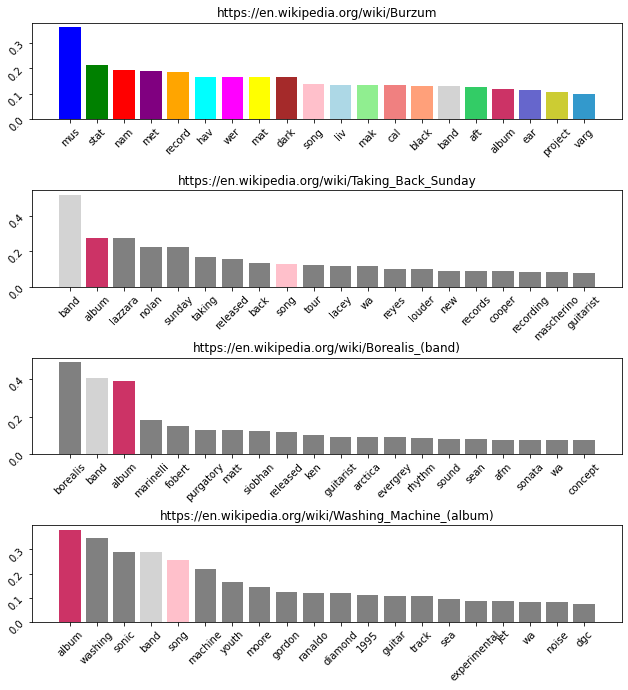

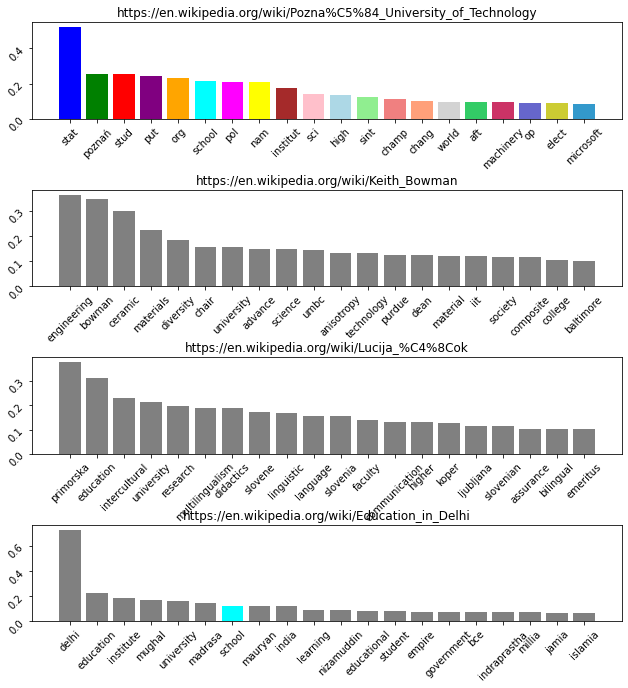

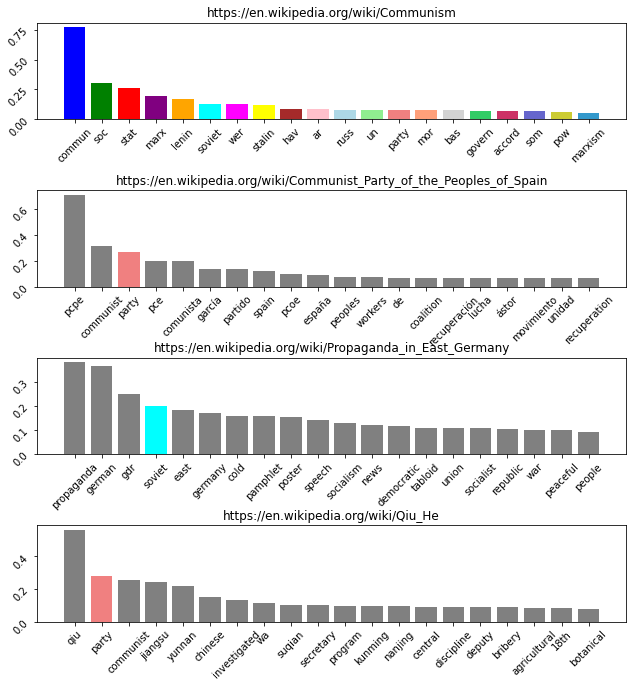

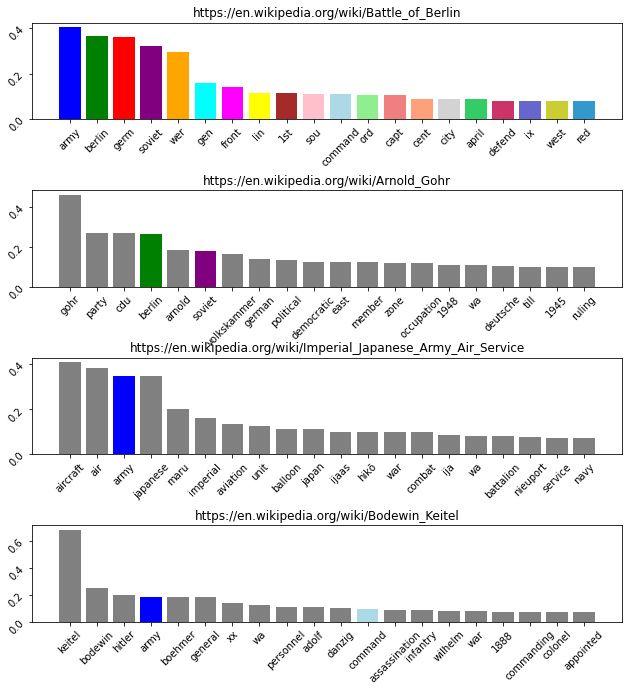

In [10]:
from src.wiki_scraper.functions.explainer import *

explain(df,tfidf,recommend_articles(df,tfidf,[
    "https://en.wikipedia.org/wiki/FIFA_World_Cup",
    "https://en.wikipedia.org/wiki/Burzum",
    "https://en.wikipedia.org/wiki/Pozna%C5%84_University_of_Technology",
    "https://en.wikipedia.org/wiki/Communism",
    "https://en.wikipedia.org/wiki/Battle_of_Berlin"
]))

The model explainer shows 20 words, that best describe the article according to the tfidf measures, for the query article and each of the recommendations. It colors the words for each recommendation which appears in the query.

## Recommender System Application

To use the recommender system a CLI application was developed which connects the steps describe in this report:
- py .\recommend.py -h - arguments description